In [21]:
import numpy as np
import pandas as pd
import os
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import zoom

from contrastive.augmentations import SimplifyTensor, PaddingTensor, RemoveRandomBranchTensor, PartialCutOutTensor_Roll, BinarizeTensor, RotateTensor

In [22]:
class ResizeTensor(object):
    """Apply resize to a 3D image
    """

    def __init__(self, resize_ratio):
        self.resize_ratio = resize_ratio

    def __call__(self, tensor):
        arr = tensor.numpy()
        resized_arr = np.copy(arr)
        resized_arr = zoom(resized_arr,
                           self.resize_ratio,
                           order=0)

        return torch.from_numpy(resized_arr)

In [5]:
#skels = np.load("/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/crops/2mm/CINGULATE/mask/subsets/Rskeleton_most_folded_551.npy")
#foldlabels = np.load("/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/crops/2mm/CINGULATE/mask/subsets/Rlabel_most_folded_551.npy")

skels = np.load("/neurospin/dico/data/deep_folding/papers/miccai2023/Input/datasets/hcp/crops/2mm/CINGULATE/mask/Rskeleton.npy")
foldlabels = np.load("/neurospin/dico/data/deep_folding/papers/miccai2023/Input/datasets/hcp/crops/2mm/CINGULATE/mask/Rlabel.npy")

In [11]:
#for displaying purpose, don't rotate the image in transform
#foldlabel + cutout
"""
def transformation(sample_foldlabel,
                   percentage,
                   from_skeleton,
                   input_size,
                   fill_value,
                   variable_percentage,
                   keep_bottom,
                   patch_size,
                   max_angle):
    
    return \
    transforms.Compose([
        SimplifyTensor(),
        PaddingTensor(shape=input_size,
                    fill_value=fill_value),
        RemoveRandomBranchTensor(sample_foldlabel=sample_foldlabel,
                                percentage=percentage,
                                variable_percentage = variable_percentage,
                                input_size=input_size,
                                keep_bottom=keep_bottom),
        PartialCutOutTensor_Roll(from_skeleton=from_skeleton,
                                 keep_bottom=keep_bottom,
                                 patch_size=patch_size),

        BinarizeTensor(),
        RotateTensor(max_angle=max_angle)
    ])
"""

In [18]:
#for displaying purpose, don't rotate the image in transform
#foldlabel + resize

def transformation(sample_foldlabel,
                   percentage,
                   input_size,
                   variable_percentage,
                   keep_bottom,
                   max_angle,
                   resize_ratio):
    
    return \
transforms.Compose([
    SimplifyTensor(),
    RemoveRandomBranchTensor(sample_foldlabel=sample_foldlabel,
                            percentage=percentage,
                            variable_percentage = variable_percentage,
                            input_size=input_size,
                            keep_bottom=keep_bottom),
    BinarizeTensor(),
    RotateTensor(max_angle=max_angle),
    ResizeTensor(resize_ratio)
])

In [24]:
#parameters used
input_size=(1,21,48,49)

##Resize
resize_ratio = (21/17, 48/40, 49/38, 1) #twice as many voxels

##branch clipping
percentage=0
variable_percentage=False
##

##cutout
patch_size=(1,0,0,0) #no cutout
#patch_size=(1,7,17,16)
keep_bottom=True
##

##rotation
max_angle=0 #no rotation
##

In [26]:
resize_ratio

(1.2352941176470589, 1.2, 1.2894736842105263, 1)

In [14]:
def mask(foldlabel, skeleton):

    """
    Mask the branches removed in the transformed skeleton. Use only if rotation angle is 0
    Output is a foldlabel with a mask. Works only with removal transformations...
    """

    return 0

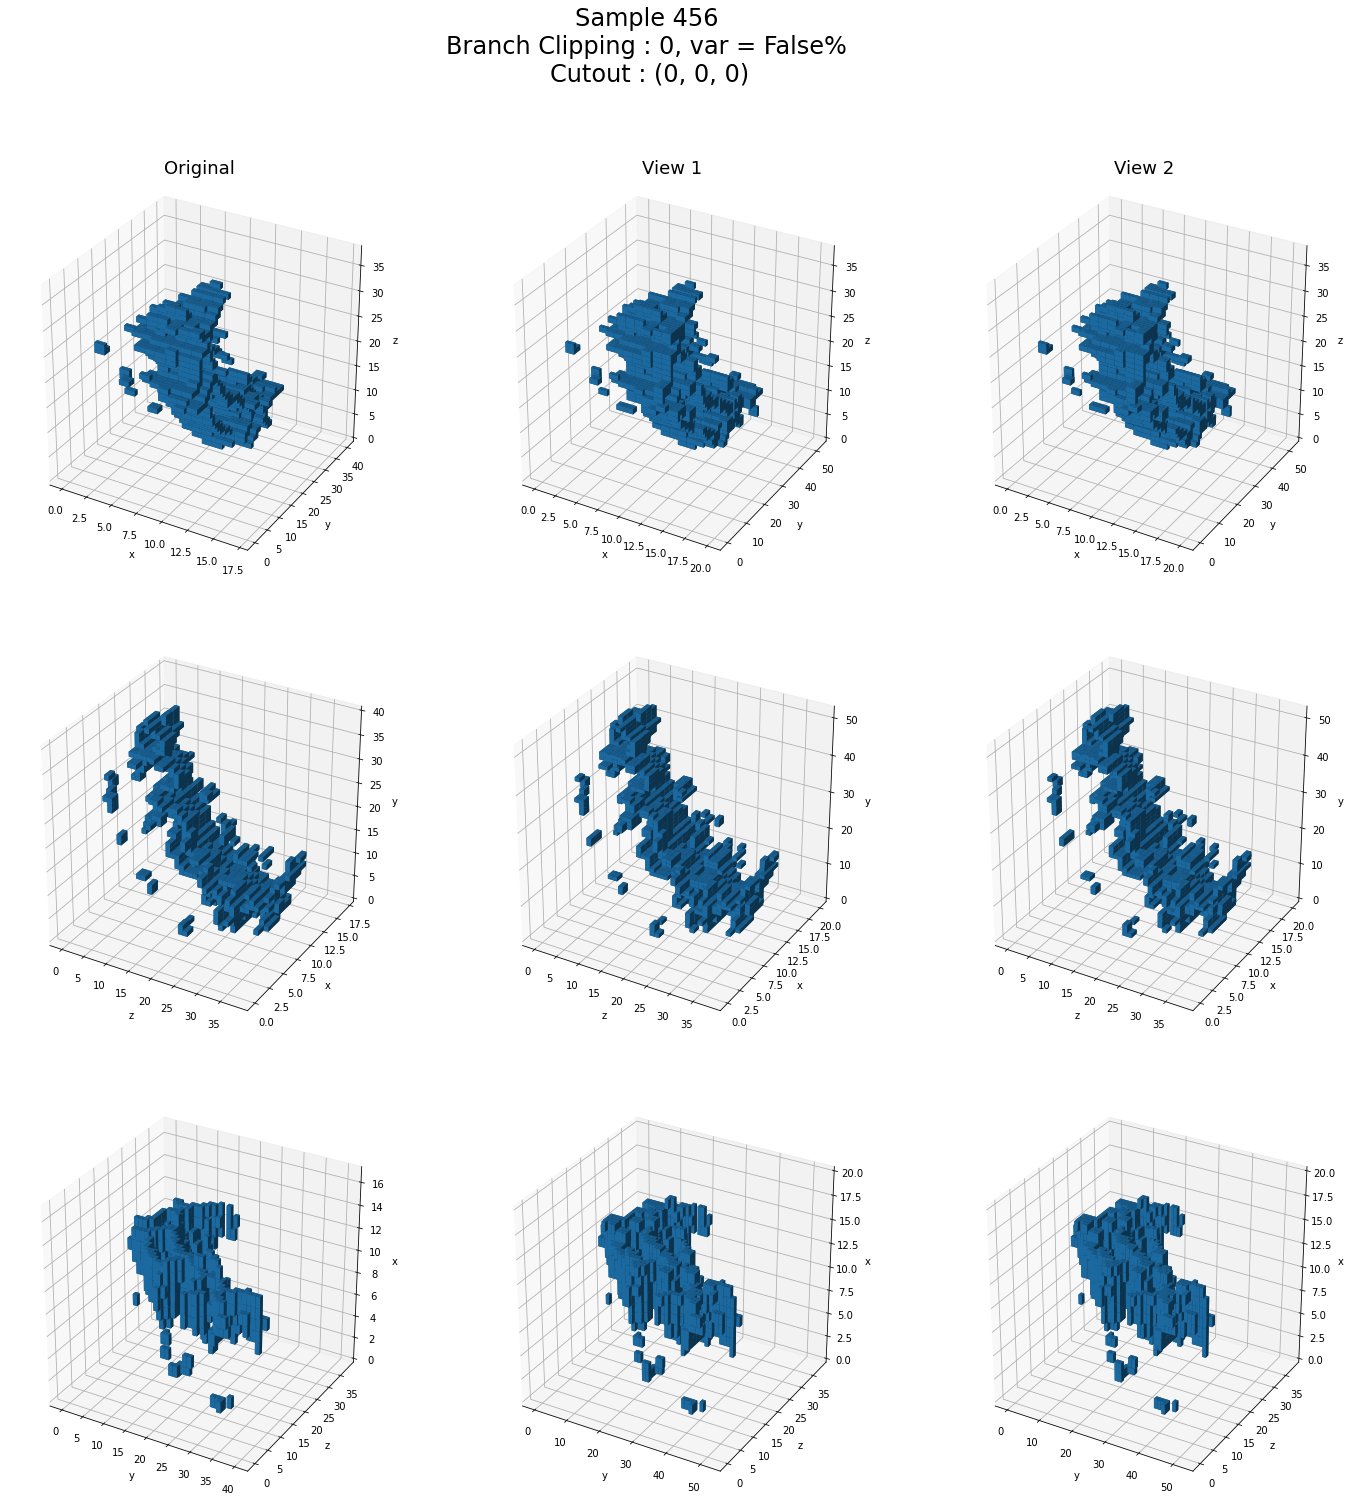

In [25]:
#select indexes
nb_image=1
indexes = np.random.randint(0,skels.shape[0],nb_image)

#loop over random images
for index in indexes:
    #get the tensors
    skeleton = skels[index].astype("float32")
    skeleton = torch.from_numpy(skeleton) #not used here
    foldlab = foldlabels[index].astype("int32")
    foldlabel = torch.from_numpy(foldlab)

    transfo1 = transformation(sample_foldlabel=foldlabel,
                            percentage=percentage,
                            input_size=input_size,
                            variable_percentage=variable_percentage,
                            keep_bottom=keep_bottom,
                            max_angle=max_angle,
                            resize_ratio=resize_ratio)

    transfo2 = transformation(sample_foldlabel=foldlabel,
                            percentage=percentage,
                            input_size=input_size,
                            variable_percentage=variable_percentage,
                            keep_bottom=keep_bottom,
                            max_angle=max_angle,
                            resize_ratio=resize_ratio)

    #apply transfo to the original image to create two views, and convert to np array
    view1 = transfo1(foldlabel).numpy()
    view2 = transfo2(foldlabel).numpy()

    #remove 4th dimension
    skel = skels[index][:,:,:,0]
    view_1=view1[0,:,:,:]
    view_2=view2[0,:,:,:]

    dict_to_plot = {'Original': skel,
                    'View 1': view_1,
                    'View 2': view_2}


    #plot original image and the two views along three different directions
    fig = plt.figure(figsize=(24,24))

    #plot original image
    for idx,(name, im) in enumerate(dict_to_plot.items()):
        for i,order in enumerate([('x','y','z'), ('z','x','y'), ('y','z','x')]):
            ax = fig.add_subplot(3,3,3*i+idx+1,projection='3d')
            ax.voxels(im)
            ax.set_xlabel(order[0])
            ax.set_ylabel(order[1])
            ax.set_zlabel(order[2])
            ax.set_box_aspect([1,1,1])
            if i == 0:
                ax.set_title(name,fontsize=18)
            #transpose im for next plot
            im = im.transpose(2,0,1)

    plt.suptitle(f'Sample {index} \nBranch Clipping : {percentage}, var = {variable_percentage}% \nCutout : {patch_size[1:]}', fontsize=24)
    plt.show()